# $\textbf{Import Library}$ 

In [27]:
import os
#os.environ['CRDS_PATH'] = '/fenrirdata1/kg_data/crds_cache/' #These pathways should be defined in your ~./bash profile. If not, you can set them within the notebook.
#os.environ['CRDS_SERVER_URL']= 'https://jwst-crds.stsci.edu'
os.environ['CRDS_CONTEXT']='jwst_0756.pmap' #Occasionally, the JWST CRDS pmap will be updated. Updates may break existing code. Use this command to revert to an older working verison until the issue is fixed. 


import jwst
print(jwst.__version__) #Print what version of the pipeline you are using.

from jwst.pipeline.calwebb_detector1 import Detector1Pipeline #Stage 1
from jwst.pipeline.calwebb_image2 import Image2Pipeline #Stage 2
from jwst.pipeline.calwebb_tso3 import Tso3Pipeline #Stage 3
from jwst.associations.asn_from_list import asn_from_list #Association file imports
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

#General
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
import csv
import numpy as np
import ref_pixels
import asdf
import astropy.units as u
import glob
import time
import yaml
%matplotlib inline

from tshirt.pipeline import phot_pipeline #tshirt specific imports
from splintegrate import splintegrate

#Style Choice
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

1.3.1
[matplotlib.pyplot:DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.


# $\textbf{Stage 1}$
### $\textbf{Detector-level corrections and ramp fitting for individual exposures.}$
Stage 1 consists of detector-level corrections that are performed on a group-by-group basis, followed by ramp fitting.
The output of stage 1 processing is a countrate image per exposure, or per integration for some modes.

#### $\textbf{Detector1Pipeline:}$
Apply all calibration steps to raw JWST ramps to produce a 2-D slope product. This stage takes care of basic data reduction steps, such as reference pixel correction, superbias subtraction, removal of non-linearity, and flagging of cosmic rays. In the final step in this stage of the pipeline, line-fitting is performed on each integration. A slope image is created for each integration. The steps in this stage are identical for all data.

There are two general configurations for this pipeline, depending on whether the data are to be treated as a Time Series Observation (TSO). The configuration is provided by CRDS reference file mappings and are usually set by default to always give access to the most recent reference file deliveries and selection rules. For TSO exposures, <mark>some steps are set to be skipped by default</mark>:

- The <mark>$\textbf{ipc}$</mark> step corrects a JWST exposure for interpixel capacitance by convolving with an IPC reference image.
- The <mark>$\textbf{persistence}$</mark> step. Based on a model, this step computes the number of traps that are expected to have captured or released a charge during an exposure. The released charge is proportional to the persistence signal, and this will be subtracted (group by group) from the science data. 

$\textbf{INPUT FILES:}$
Exposure raw data products are designated by a file name suffix of “uncal.” These files usually contain only the raw detector pixel values from an exposure, with the addition of some table extensions containing various types of meta data associated with the exposure. Additional extensions can be included for certain instruments and readout types. Below are header modifications to the "uncal" fits files. 

In [13]:
#Adding header modifications
all_uncal_files = [] # All Uncalibrated File Names. Also use to check that all files have been modified by the loop. 
BaseDirectory = '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data/'
for fitsName in glob.glob(BaseDirectory + '*seg013_nrca3_uncal.fits'): #Grabbing only nrca3 files from the directory
    HDUList = fits.open(fitsName)
    HDUList[0].header['NOUTPUTS'] = (4, 'Number of output amplifiers') #This was not input at the time of the simulation. Therefore, we manually must input this information. 
    HDUList[1].header['XREF_SCI'] = (1055.0, 'Aperture X reference point in SCI frame') #Fix x-position centering
    HDUList[1].header['YREF_SCI'] = (23.0, 'Aperture Y reference point in SCI frame') #Fix the y-position centering
    HDUList.close()
    all_uncal_files.append(fitsName)
    
all_uncal_files = sorted(all_uncal_files) #sort files alphabetically. 

[py.warnings:WARNING] /tmp/ipykernel_335294/1732377619.py:5: ResourceWarning: unclosed file <_io.FileIO name='/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data/jw00042001001_01101_00001-seg003_nrca3_uncal.fits' mode='rb' closefd=True>
  HDUList = fits.open(fitsName)



In [36]:
startTime = time.time() #Time how long this step takes

for filename_stage1 in all_uncal_files:
    
    # Instantiate the class. Do not provide a configuration file.
    pipeline_stage1 = Detector1Pipeline()
    
    # Manually set any desired non-default parameter values
    
    # Default is to skip the persistence and IPC correction
    # Make that explicit here
    pipeline_stage1.persistence.skip = True
    pipeline_stage1.ipc.skip = True
    
    pipeline_stage1.refpix.skip = False # Make sure to skip steps appropriate if using an alternate ref pix correction method. Otherwise, the default is 'False'.
    pipeline_stage1.superbias.skip = False 
    
    # The default value for CR flagging is 3 or 4 sigma
    # which tends to be too aggressive and flags noise.
    # Set it to something more reasonable
    #pipeline_stage1.jump.rejection_threshold = 9
    pipeline_stage1.jump.skip=True # Currently we are skipping this step as we are testing the pipeline with this simulation and lots of the data gets flagged. 
    
    # Specify that you want results saved to a file
    pipeline_stage1.save_results = True
    pipeline_stage1.output_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True'
    
    # Execute the pipeline using the run method
    result_stage1 = pipeline_stage1.run(filename_stage1)
    
executionTime = (time.time() - startTime)
print('Stage 1 Execution Time in Seconds: ' + str(executionTime)) #Time how long this step takes

2021-09-29 13:38:17,964 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


[stpipe.Detector1Pipeline:INFO] Detector1Pipeline instance created.


2021-09-29 13:38:17,968 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


[stpipe.Detector1Pipeline.group_scale:INFO] GroupScaleStep instance created.


2021-09-29 13:38:17,973 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


[stpipe.Detector1Pipeline.dq_init:INFO] DQInitStep instance created.


2021-09-29 13:38:17,977 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


[stpipe.Detector1Pipeline.saturation:INFO] SaturationStep instance created.


2021-09-29 13:38:17,981 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


[stpipe.Detector1Pipeline.ipc:INFO] IPCStep instance created.


2021-09-29 13:38:17,985 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


[stpipe.Detector1Pipeline.superbias:INFO] SuperBiasStep instance created.


2021-09-29 13:38:17,990 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


[stpipe.Detector1Pipeline.refpix:INFO] RefPixStep instance created.


2021-09-29 13:38:17,994 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


[stpipe.Detector1Pipeline.rscd:INFO] RscdStep instance created.


2021-09-29 13:38:17,998 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


[stpipe.Detector1Pipeline.firstframe:INFO] FirstFrameStep instance created.


2021-09-29 13:38:18,002 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


[stpipe.Detector1Pipeline.lastframe:INFO] LastFrameStep instance created.


2021-09-29 13:38:18,006 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


[stpipe.Detector1Pipeline.linearity:INFO] LinearityStep instance created.


2021-09-29 13:38:18,011 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


[stpipe.Detector1Pipeline.dark_current:INFO] DarkCurrentStep instance created.


2021-09-29 13:38:18,016 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


[stpipe.Detector1Pipeline.reset:INFO] ResetStep instance created.


2021-09-29 13:38:18,022 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


[stpipe.Detector1Pipeline.persistence:INFO] PersistenceStep instance created.


2021-09-29 13:38:18,029 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


[stpipe.Detector1Pipeline.jump:INFO] JumpStep instance created.


2021-09-29 13:38:18,034 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


[stpipe.Detector1Pipeline.ramp_fit:INFO] RampFitStep instance created.


2021-09-29 13:38:18,039 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


[stpipe.Detector1Pipeline.gain_scale:INFO] GainScaleStep instance created.


2021-09-29 13:38:18,322 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data/jw00042001001_01101_00001-seg013_nrca3_uncal.fits',).


[stpipe.Detector1Pipeline:INFO] Step Detector1Pipeline running with args ('/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data/jw00042001001_01101_00001-seg013_nrca3_uncal.fits',).


2021-09-29 13:38:18,357 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 

[stpipe.Detector1Pipeline:INFO] Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hoo

2021-09-29 13:38:19,918 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


[stpipe.Detector1Pipeline:INFO] Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2021-09-29 13:38:19,930 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0198.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for DARK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0198.fits'.


2021-09-29 13:38:19,932 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.


2021-09-29 13:38:19,934 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for LINEARITY reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits'.


2021-09-29 13:38:19,937 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0041.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for MASK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0041.fits'.


2021-09-29 13:38:19,939 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.


2021-09-29 13:38:19,941 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


[stpipe.Detector1Pipeline:INFO] Prefetch for REFPIX reference file is 'N/A'.


2021-09-29 13:38:19,943 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


[stpipe.Detector1Pipeline:INFO] Prefetch for RESET reference file is 'N/A'.


2021-09-29 13:38:19,944 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


[stpipe.Detector1Pipeline:INFO] Prefetch for RSCD reference file is 'N/A'.


2021-09-29 13:38:19,946 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0067.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for SATURATION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0067.fits'.


2021-09-29 13:38:19,950 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0027.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for SUPERBIAS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0027.fits'.
[      root:INFO] Starting calwebb_detector1 ...
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[      root:DEBUG] Processing a Near-IR exposure


2021-09-29 13:38:24,821 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.group_scale:INFO] Step group_scale running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:38:24,824 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.group_scale:INFO] Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:38:28,906 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


[stpipe.Detector1Pipeline.group_scale:INFO] NFRAMES=1 is a power of 2; correction not needed


2021-09-29 13:38:28,908 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


[stpipe.Detector1Pipeline.group_scale:INFO] Step will be skipped


2021-09-29 13:38:28,910 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


[stpipe.Detector1Pipeline.group_scale:INFO] Step group_scale done


2021-09-29 13:38:29,181 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.dq_init:INFO] Step dq_init running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:38:29,186 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.dq_init:INFO] Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:38:29,257 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0041.fits


[stpipe.Detector1Pipeline.dq_init:INFO] Using MASK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0041.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.dq_init.dq_initialization:INFO] Extracting mask subarray to match science data
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, x

2021-09-29 13:38:36,283 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


[stpipe.Detector1Pipeline.dq_init:INFO] Step dq_init done


2021-09-29 13:38:36,566 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.saturation:INFO] Step saturation running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:38:36,570 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.saturation:INFO] Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:38:36,626 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0067.fits


[stpipe.Detector1Pipeline.saturation:INFO] Using SATURATION reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0067.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword NO_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword FEW_SAMPLES does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword AD_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword WEIRD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword DEAD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored


[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.saturation.saturation:INFO] Extracting reference file subarray to match science data
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=143, ystop=207
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.saturation.saturation:INFO] Detected 519 saturated pixels
[jwst.saturation.saturation:INFO] Detected 0 A/D floor pixels


2021-09-29 13:38:47,786 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


[stpipe.Detector1Pipeline.saturation:INFO] Step saturation done


2021-09-29 13:38:48,161 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.ipc:INFO] Step ipc running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:38:48,165 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.ipc:INFO] Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


2021-09-29 13:38:48,167 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


[stpipe.Detector1Pipeline.ipc:INFO] Step skipped.


2021-09-29 13:38:48,168 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


[stpipe.Detector1Pipeline.ipc:INFO] Step ipc done


2021-09-29 13:38:48,438 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.superbias:INFO] Step superbias running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:38:48,441 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.superbias:INFO] Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:38:48,496 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0027.fits


[stpipe.Detector1Pipeline.superbias:INFO] Using SUPERBIAS reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0027.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored


[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=143, ystop=207
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:38:53,918 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


[stpipe.Detector1Pipeline.superbias:INFO] Step superbias done


2021-09-29 13:38:54,204 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.refpix:INFO] Step refpix running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:38:54,207 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


[stpipe.Detector1Pipeline.refpix:INFO] Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:38:54,234 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


[stpipe.Detector1Pipeline.refpix:INFO] use_side_ref_pixels = True


2021-09-29 13:38:54,235 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


[stpipe.Detector1Pipeline.refpix:INFO] odd_even_columns = True


2021-09-29 13:38:54,236 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


[stpipe.Detector1Pipeline.refpix:INFO] side_smoothing_length = 11


2021-09-29 13:38:54,238 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


[stpipe.Detector1Pipeline.refpix:INFO] side_gain = 1.000000


2021-09-29 13:38:54,239 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


[stpipe.Detector1Pipeline.refpix:INFO] odd_even_rows = True
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] Input exposure is a subarray readout
[jwst.lib.reffile_utils:DEBUG] Input exposure is a subarray readout


2021-09-29 13:46:50,870 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


[stpipe.Detector1Pipeline.refpix:INFO] Step refpix done


2021-09-29 13:46:51,311 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.linearity:INFO] Step linearity running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:46:51,316 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.linearity:INFO] Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:46:51,373 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits


[stpipe.Detector1Pipeline.linearity:INFO] Using Linearity reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.linearity.linearity:INFO] Extracting linearity subarray to match science data
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=143, ystop=207
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=143, ystop=207
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot 

2021-09-29 13:46:58,549 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


[stpipe.Detector1Pipeline.linearity:INFO] Step linearity done


2021-09-29 13:46:58,900 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.persistence:INFO] Step persistence running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:46:58,904 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


[stpipe.Detector1Pipeline.persistence:INFO] Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2021-09-29 13:46:58,905 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


[stpipe.Detector1Pipeline.persistence:INFO] Step skipped.


2021-09-29 13:46:58,907 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


[stpipe.Detector1Pipeline.persistence:INFO] Step persistence done


2021-09-29 13:46:59,178 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.dark_current:INFO] Step dark_current running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:46:59,181 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'dark_output': None}


[stpipe.Detector1Pipeline.dark_current:INFO] Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'dark_output': None}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:46:59,238 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0198.fits


[stpipe.Detector1Pipeline.dark_current:INFO] Using DARK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0198.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword HIGH_NOISE does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UNSTABLE_NOISE does not correspond to an existing DQ mnemonic, so will be ignored


[jwst.dark_current.dark_sub:INFO] Science data nints=152, ngroups=8, nframes=1, groupgap=0
[jwst.dark_current.dark_sub:INFO] Dark data nints=1, ngroups=20, nframes=1, groupgap=0
[jwst.dark_current.dark_sub:DEBUG] subtract_dark: nints=152, ngroups=8, size=64,2048
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:47:02,969 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


[stpipe.Detector1Pipeline.dark_current:INFO] Step dark_current done


2021-09-29 13:47:03,333 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.jump:INFO] Step jump running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:47:03,337 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


[stpipe.Detector1Pipeline.jump:INFO] Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-09-29 13:47:03,339 - stpipe.Detector1Pipeline.jump - INFO - Step skipped.


[stpipe.Detector1Pipeline.jump:INFO] Step skipped.


2021-09-29 13:47:03,341 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


[stpipe.Detector1Pipeline.jump:INFO] Step jump done


2021-09-29 13:47:03,608 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.ramp_fit:INFO] Step ramp_fit running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:47:03,611 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


[stpipe.Detector1Pipeline.ramp_fit:INFO] Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cann

2021-09-29 13:49:52,290 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


[stpipe.Detector1Pipeline.ramp_fit:INFO] Step ramp_fit done


2021-09-29 13:49:52,665 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale running with args (<ImageModel(64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:49:52,669 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "F

2021-09-29 13:49:52,774 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


[stpipe.Detector1Pipeline.gain_scale:INFO] GAINFACT not found in gain reference file


2021-09-29 13:49:52,776 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


[stpipe.Detector1Pipeline.gain_scale:INFO] Step will be skipped


2021-09-29 13:49:52,780 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale done


2021-09-29 13:49:53,067 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:49:53,071 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value o

2021-09-29 13:49:53,173 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


[stpipe.Detector1Pipeline.gain_scale:INFO] GAINFACT not found in gain reference file


2021-09-29 13:49:53,175 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


[stpipe.Detector1Pipeline.gain_scale:INFO] Step will be skipped


2021-09-29 13:49:53,180 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale done


2021-09-29 13:49:54,225 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rateints.fits


[stpipe.Detector1Pipeline:INFO] Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rateints.fits
[      root:INFO] ... ending calwebb_detector1


2021-09-29 13:49:54,353 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rate.fits


[stpipe.Detector1Pipeline:INFO] Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rate.fits


2021-09-29 13:49:54,356 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


[stpipe.Detector1Pipeline:INFO] Step Detector1Pipeline done
Stage 1 Execution Time in Seconds: 696.4182014465332


$\textbf{OUTPUT FILES:}$ Output files are \*rateints.fits. The pipeline creates a rate.fits and a rateint.fits files in cases where there is more than one integration in a file, but only a rate.fits file in the case where there is only one integration in a file.

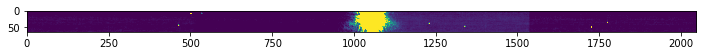

In [42]:
#A check to ensure the star is in the file
file = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rateints.fits' #random file from the rateints list
HDUList = fits.open(file)
#HDUList.info()

image2D = HDUList[1].data[0]
image2D.shape

fig, ax = plt.subplots(figsize=(12,5))
ax.imshow(image2D, vmin=0, vmax=50)
#ax.plot(image2D[32,:])
#ax.set_xlim(900,1000)

## $\textbf{Association Files}$
#### $\textbf{Organizing the Detector1Pipeline Output Files}$
Associations are basically just lists of things, mostly exposures, that are somehow related. An association file is a JSON-format file that contains a list of all the files with the same instrument set-up (filter, observation mode, etc) that might be combined into a single image. Relationships between multiple exposures are captured in an association, which is a means of identifying a set of exposures that belong together and may be dependent upon one another. The association concept permits exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

In [37]:
asn_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True'
level2_asn = (os.path.join(asn_dir, 'level2_asn.json'))
asn_stage2 = asn_from_list(['/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rateints.fits'],rule=DMSLevel2bBase)
with open(level2_asn, 'w') as fh:
   fh.write(asn_stage2.dump()[1])

# $\textbf{Stage 2}$
### $\textbf{Processes JWST imaging-mode slope data from Level-2a to Level-2b.}$
Stage 2 processing consists of additional instrument-level and observing-mode corrections and calibrations to produce fully calibrated exposures. The details differ for imaging and spectroscopic exposures, and there are some corrections that are unique to certain instruments or modes. 

#### $\textbf{Image2Pipeline:}$
Imaging processing applies additional instrumental corrections and calibrations that result in a fully calibrated individual exposure. Imaging TSO data are run through this pipeline. The steps are very similar to those in Spec2Pipeline. WCS information is added, flat fielding and flux calibration are performed, and astrometric distortion is removed from the images. There are two parameter references used to control this pipeline, depending on whether the data are to be treated as Time Series Observation (TSO). The parameter reference is provided by CRDS. For TSO exposures, some steps are set to be skipped by default.

$\textbf{INPUT FILES:}$
The input to Image2Pipeline is a countrate exposure, in the form of either “_rate” or “_rateints” data. A single input file can be processed or an ASN file listing multiple inputs can be used, in which case the processing steps will be applied to each input exposure, one at a time. If “_rateints” products are used as input, each step applies its algorithm to each integration in the exposure, where appropriate.

In [38]:
#The file to use is the stage 2 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage2 = Image2Pipeline()

# Specify that you want results saved to a file
pipeline_stage2.save_results = True
pipeline_stage2.output_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True'

# Execute the pipeline using the run method
result_stage2 = pipeline_stage2.run(level2_asn)

2021-09-29 13:49:54,394 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


[stpipe.Image2Pipeline:INFO] Image2Pipeline instance created.


2021-09-29 13:49:54,398 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


[stpipe.Image2Pipeline.bkg_subtract:INFO] BackgroundStep instance created.


2021-09-29 13:49:54,403 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


[stpipe.Image2Pipeline.assign_wcs:INFO] AssignWcsStep instance created.


2021-09-29 13:49:54,408 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


[stpipe.Image2Pipeline.flat_field:INFO] FlatFieldStep instance created.


2021-09-29 13:49:54,413 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


[stpipe.Image2Pipeline.photom:INFO] PhotomStep instance created.


2021-09-29 13:49:54,418 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


[stpipe.Image2Pipeline.resample:INFO] ResampleStep instance created.


2021-09-29 13:49:54,868 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/level2_asn.json',).


[stpipe.Image2Pipeline:INFO] Step Image2Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/level2_asn.json',).


2021-09-29 13:49:54,881 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'su

[stpipe.Image2Pipeline:INFO] Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_

2021-09-29 13:49:55,316 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


[stpipe.Image2Pipeline:INFO] Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-09-29 13:49:55,329 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0031.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for AREA reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0031.fits'.


2021-09-29 13:49:55,332 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for CAMERA reference file is 'N/A'.


2021-09-29 13:49:55,335 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for COLLIMATOR reference file is 'N/A'.


2021-09-29 13:49:55,338 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for DFLAT reference file is 'N/A'.


2021-09-29 13:49:55,341 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for DISPERSER reference file is 'N/A'.


2021-09-29 13:49:55,343 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_distortion_0089.asdf'.


[stpipe.Image2Pipeline:INFO] Prefetch for DISTORTION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_distortion_0089.asdf'.


2021-09-29 13:49:55,352 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for DRIZPARS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


2021-09-29 13:49:55,356 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for FFLAT reference file is 'N/A'.


2021-09-29 13:49:55,358 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_filteroffset_0004.asdf'.


[stpipe.Image2Pipeline:INFO] Prefetch for FILTEROFFSET reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_filteroffset_0004.asdf'.


2021-09-29 13:49:55,364 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_flat_0298.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for FLAT reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_flat_0298.fits'.


2021-09-29 13:49:55,367 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for FORE reference file is 'N/A'.


2021-09-29 13:49:55,369 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for FPA reference file is 'N/A'.


2021-09-29 13:49:55,372 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for IFUFORE reference file is 'N/A'.


2021-09-29 13:49:55,374 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for IFUPOST reference file is 'N/A'.


2021-09-29 13:49:55,378 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for IFUSLICER reference file is 'N/A'.


2021-09-29 13:49:55,380 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for MSA reference file is 'N/A'.


2021-09-29 13:49:55,382 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for OTE reference file is 'N/A'.


2021-09-29 13:49:55,386 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for PHOTOM reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits'.


2021-09-29 13:49:55,389 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for REGIONS reference file is 'N/A'.


2021-09-29 13:49:55,391 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for SFLAT reference file is 'N/A'.


2021-09-29 13:49:55,394 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for SPECWCS reference file is 'N/A'.


2021-09-29 13:49:55,397 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-09-29 13:49:55,399 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for WFSSBKG reference file is 'N/A'.


2021-09-29 13:49:55,401 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


[stpipe.Image2Pipeline:INFO] Starting calwebb_image2 ...


2021-09-29 13:49:55,437 - stpipe.Image2Pipeline - INFO - Processing product /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3


[stpipe.Image2Pipeline:INFO] Processing product /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3


2021-09-29 13:49:55,439 - stpipe.Image2Pipeline - INFO - Working on input /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rateints.fits ...


[stpipe.Image2Pipeline:INFO] Working on input /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rateints.fits ...
[jwst.datamodels.util:DEBUG] Opening /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rateints.fits as <class 'jwst.datamodels.cube.CubeModel'>
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] FITS hash matches. Skipping FITS updating.
[stdatamodels.fits_support:DEBUG] Skipping FITS keyword updating except for BinTableHDU and its associated header keywords.


2021-09-29 13:49:56,165 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


[stpipe.Image2Pipeline.assign_wcs:INFO] Step assign_wcs running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


2021-09-29 13:49:56,170 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


[stpipe.Image2Pipeline.assign_wcs:INFO] Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be fou

[py.warnings:WARNING] /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



[jwst.assign_wcs.util:INFO] Update S_REGION to POLYGON ICRS  175.560846873 26.702895140 175.560844974 26.703457812 175.540802246 26.703431012 175.540794772 26.702865173
[jwst.assign_wcs.assign_wcs:INFO] assign_wcs updated S_REGION to POLYGON ICRS  175.560846873 26.702895140 175.560844974 26.703457812 175.540802246 26.703431012 175.540794772 26.702865173
[jwst.assign_wcs.assign_wcs:INFO] COMPLETED assign_wcs


2021-09-29 13:49:57,220 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


[stpipe.Image2Pipeline.assign_wcs:INFO] Step assign_wcs done


2021-09-29 13:49:57,545 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


[stpipe.Image2Pipeline.flat_field:INFO] Step flat_field running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


2021-09-29 13:49:57,548 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


[stpipe.Image2Pipeline.flat_field:INFO] Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stpipe.Image2Pipeline.flat_field:DEBUG] Input is CubeModel of exposure type NRC_TSIMAGE
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using defau

2021-09-29 13:50:01,948 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


[stpipe.Image2Pipeline.flat_field:INFO] Step flat_field done


2021-09-29 13:50:02,272 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


[stpipe.Image2Pipeline.photom:INFO] Step photom running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


2021-09-29 13:50:02,276 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'inverse': False, 'source_type': None}


[stpipe.Image2Pipeline.photom:INFO] Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'inverse': False, 'source_type': None}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stpipe.Image2Pipeline.photom:DEBUG] Input is CubeModel
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" c

2021-09-29 13:50:02,361 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits


[stpipe.Image2Pipeline.photom:INFO] Using photom reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits


2021-09-29 13:50:02,363 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0031.fits


[stpipe.Image2Pipeline.photom:INFO] Using area reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0031.fits
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.photom.photom:INFO] Using instrument: NIRCAM
[jwst.photom.photom:INFO]  detector: NRCA3
[jwst.photom.photom:INFO]  exp_type: NRC_TSIMAGE
[jwst.photom.photom:INFO]  filter: WLP4
[jwst.photom.photom:INFO]  pupil: CLEAR
[jwst.datamodels.util:DEBUG] Opening /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits as <class 'jwst.datamodels.photom.NrcImgPhotomModel'>
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.f

2021-09-29 13:50:04,220 - stpipe.Image2Pipeline.photom - INFO - Step photom done


[stpipe.Image2Pipeline.photom:INFO] Step photom done


2021-09-29 13:50:04,222 - stpipe.Image2Pipeline - INFO - Finished processing product /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3


[stpipe.Image2Pipeline:INFO] Finished processing product /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3


2021-09-29 13:50:04,224 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


[stpipe.Image2Pipeline:INFO] ... ending calwebb_image2


2021-09-29 13:50:06,383 - stpipe.Image2Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_calints.fits


[stpipe.Image2Pipeline:INFO] Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_calints.fits


2021-09-29 13:50:06,385 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[stpipe.Image2Pipeline:INFO] Step Image2Pipeline done


$\textbf{OUTPUT FILES:}$ The output is a fully calibrated, but unrectified, exposure, using the product type suffix “_cal” or “_calints”, depending on the type of input.

In [39]:
#generate an association file required for stage 3
asn_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True'
level3_asn = (os.path.join(asn_dir, 'level3_asn.json'))
asn_stage3 = asn_from_list(['/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_calints.fits'], product_name ='DataChallengeSimulation_nrca3_level3_asn')
with open(level3_asn, 'w') as fh:
   fh.write(asn_stage3.dump()[1])

# $\textbf{Stage 3}$
### $\textbf{Applies level 3 processing to TSO-mode data from}$
Stage 3 processing consists of routines that work with multiple exposures and in most cases produce some kind of combined product. There are unique pipeline modules for stage 3 processing of imaging, spectroscopic, coronagraphic, AMI, and TSO observations. 

#### $\textbf{Tso3Pipeline:}$
The Stage 3 TSO pipeline is to be applied to associations of calibrated TSO exposures (e.g. NIRCam TS imaging, NIRCam TS grism, NIRISS SOSS, NIRSpec BrightObj, MIRI LRS Slitless) and is used to produce calibrated time-series photometry or spectra of the source object. This is a pipeline customized for TSO data. Grism TSO data undergo outlier detection (essentially a check for any cosmic rays/transient effects that were missed in Detector1Pipeline), background subtraction, spectral extraction, and photometry. Imaging TSO data are run through outlier detection, and photometry is performed.

The logic that decides whether to apply the imaging or spectroscopy steps is based on the EXP_TYPE and TSOVISIT keyword values of the input data. Imaging steps are applied if either of the following is true:

- <mark>EXP_TYPE = ‘NRC_TSIMAGE’</mark>

- EXP_TYPE = ‘MIR_IMAGE’ and TSOVISIT = True

$\textbf{INPUT FILES:}$
The spectroscopy steps will be applied in all other cases.
The input to calwebb_tso3 is in the form of an ASN file that lists multiple exposures or exposure segments of a science target. The individual inputs should be in the form of 3D calibrated (“_calints”) products from either calwebb_image2 or calwebb_spec2 processing. 

In [40]:
#The file to use is the stage 3 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage3 = Tso3Pipeline()

pipeline_stage3.outlier_detection.skip = True

# Specify that you want results saved to a file
pipeline_stage3.save_results = True
pipeline_stage3.output_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True'

# Execute the pipeline using the run method
result_stage3 = pipeline_stage3.run(level3_asn)

2021-09-29 13:50:06,419 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.


[stpipe.Tso3Pipeline:INFO] Tso3Pipeline instance created.


2021-09-29 13:50:06,427 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


[stpipe.Tso3Pipeline.outlier_detection:INFO] OutlierDetectionStep instance created.


2021-09-29 13:50:06,431 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.


[stpipe.Tso3Pipeline.tso_photometry:INFO] TSOPhotometryStep instance created.


2021-09-29 13:50:06,439 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.


[stpipe.Tso3Pipeline.extract_1d:INFO] Extract1dStep instance created.


2021-09-29 13:50:06,443 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.


[stpipe.Tso3Pipeline.white_light:INFO] WhiteLightStep instance created.


2021-09-29 13:50:06,791 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/level3_asn.json',).


[stpipe.Tso3Pipeline:INFO] Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/level3_asn.json',).


2021-09-29 13:50:06,805 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'scale_detection': False, 'steps': {'outlier_detection': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'sc

[stpipe.Tso3Pipeline:INFO] Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'scale_detection': False, 'steps': {'outlier_detection': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allo

2021-09-29 13:50:07,402 - stpipe.Tso3Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_calints.fits' reftypes = ['gain', 'readnoise']


[stpipe.Tso3Pipeline:INFO] Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_calints.fits' reftypes = ['gain', 'readnoise']


2021-09-29 13:50:07,412 - stpipe.Tso3Pipeline - INFO - Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.


[stpipe.Tso3Pipeline:INFO] Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.


2021-09-29 13:50:07,415 - stpipe.Tso3Pipeline - INFO - Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.


[stpipe.Tso3Pipeline:INFO] Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.


2021-09-29 13:50:07,417 - stpipe.Tso3Pipeline - INFO - Starting calwebb_tso3...


[stpipe.Tso3Pipeline:INFO] Starting calwebb_tso3...
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.datamodels.container:DEBUG] Filtering datasets based on allowed exptypes ['science']:
[jwst.datamodels.container:DEBUG] Files accepted for processing /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_calints.fits:
[jwst.datamodels.util:DEBUG] Opening /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_calints.fits as <class 'jwst.datamodels.cube.CubeModel'>
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of 

[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[st

[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[st

[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[st

[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[st

2021-09-29 13:50:23,413 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


[stpipe.Tso3Pipeline:INFO] Performing outlier detection on input images ...


2021-09-29 13:50:23,758 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step outlier_detection running with args (<ModelContainer>,).


2021-09-29 13:50:23,763 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-09-29 13:50:23,766 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step skipped.


2021-09-29 13:50:23,850 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection done


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step outlier_detection done


2021-09-29 13:50:24,289 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_calints.fits>,).


[stpipe.Tso3Pipeline.tso_photometry:INFO] Step tso_photometry running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_calints.fits>,).


2021-09-29 13:50:24,293 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'save_catalog': False}


[stpipe.Tso3Pipeline.tso_photometry:INFO] Step tso_photometry parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True', 'save_catalog': False}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stpipe.Tso3Pipeline.tso_photometry:DEBUG] Reference file name = /fenrirdata1/kg_data/crds_cache/references/jwst/nircam

2021-09-29 13:50:24,715 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry done


[stpipe.Tso3Pipeline.tso_photometry:INFO] Step tso_photometry done


2021-09-29 13:50:24,717 - stpipe.Tso3Pipeline - INFO - Writing Level 3 photometry catalog /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/DataChallengeSimulation_nrca3_level3_asn_phot.ecsv


[stpipe.Tso3Pipeline:INFO] Writing Level 3 photometry catalog /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/DataChallengeSimulation_nrca3_level3_asn_phot.ecsv


2021-09-29 13:50:24,759 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline done


[stpipe.Tso3Pipeline:INFO] Step Tso3Pipeline done


Pipeline Calculated Net Aperture Sum std: 5842.731863470847
Pipeline Calculated Aperture Background std: 8241.579255001307
Pipeline Calculated Annulus Mean std: 8241.579255001318
Pipeline Calculated Annulus Sum std: 8241.579255001307


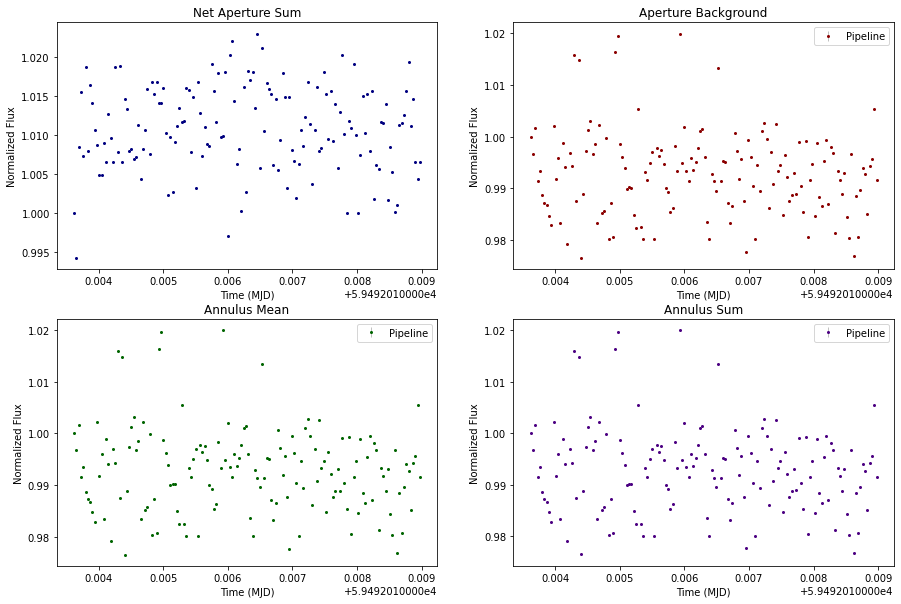

In [46]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))

#JWST pipeline: net aperture
dat = ascii.read('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/DataChallengeSimulation_nrca3_level3_asn_phot.ecsv') #call the data 
normalized_net_aperture_sum_pipeline = dat['net_aperture_sum'].value/dat['net_aperture_sum'][0].value #normalized net aperture sum
std_net_aperture_sum_pipeline = np.std(normalized_net_aperture_sum_pipeline[0:20]) #calculated standard deviation
relative_error_net_aperture_sum_pipeline = (dat['net_aperture_sum_err'].value/dat['net_aperture_sum'].value)*10**6 #ppm

print(style.BOLD+"Pipeline Calculated Net Aperture Sum std:"+style.END + " " +str(std_net_aperture_sum_pipeline*10**6))
#print(style.BOLD+"Relative Errors Net Aperture Sum:"+style.END + " " +str(relative_error_net_aperture_sum_pipeline))

axs[0,0].errorbar(dat['MJD'],normalized_net_aperture_sum_pipeline,yerr=dat['net_aperture_sum_err'].value,color='navy',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,0].set_title("Net Aperture Sum")
axs[0,0].set_xlabel("Time (MJD)")
axs[0,0].set_ylabel("Normalized Flux")

#JWST pipeline: aperature background
normalized_aperture__bkg_pipeline = dat['aperture_bkg'].value/dat['aperture_bkg'][0].value #normalized aperture bkg
std_aperture_bkg_pipeline = np.std(normalized_aperture__bkg_pipeline[0:20]) #calculated standard deviation
relative_error_aperture_bkg_pipeline = (dat['aperture_bkg_err'].value/dat['aperture_bkg'].value)*10**6 #ppm

print(style.BOLD+"Pipeline Calculated Aperture Background std:"+style.END + " " +str(std_aperture_bkg_pipeline*10**6))
#print(style.BOLD+"Relative Errors Aperture Background:"+style.END + " " +str(relative_error_aperture_bkg_pipeline))

axs[0,1].errorbar(dat['MJD'],normalized_aperture__bkg_pipeline,yerr=dat['aperture_bkg_err'].value,color='darkred',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,1].set_title("Aperture Background")
axs[0,1].set_xlabel("Time (MJD)")
axs[0,1].set_ylabel("Normalized Flux")
axs[0,1].legend()


#JWST pipeline: annulus mean
normalized_annulus_mean_pipeline = dat['annulus_mean'].value/dat['annulus_mean'][0].value #normalized annulus mean
std_annulus_mean_pipeline = np.std(normalized_annulus_mean_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_mean_pipeline = (dat['annulus_mean_err'].value/dat['annulus_mean'].value)*10**6 #ppm

print(style.BOLD+"Pipeline Calculated Annulus Mean std:"+style.END + " " +str(std_annulus_mean_pipeline*10**6))
#print(style.BOLD+"Relative Errors Annulus Mean:"+style.END + " " +str(relative_error_annulus_mean_pipeline))

axs[1,0].errorbar(dat['MJD'],normalized_annulus_mean_pipeline,yerr=dat['annulus_mean_err'].value,color ='darkgreen',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,0].set_title("Annulus Mean")
axs[1,0].set_xlabel("Time (MJD)")
axs[1,0].set_ylabel("Normalized Flux")
axs[1,0].legend()

#JWST pipeline: annulus sum
normalized_annulus_sum_pipeline = dat['annulus_sum'].value/dat['annulus_sum'][0].value #normalized annulus sum
std_annulus_sum_pipeline = np.std(normalized_annulus_sum_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_sum_pipeline = (dat['annulus_sum_err'].value/dat['annulus_sum'].value)*10**6 #ppm

print(style.BOLD+"Pipeline Calculated Annulus Sum std:"+style.END + " " +str(std_annulus_sum_pipeline*10**6))
#print(style.BOLD+"Relative Errors Annulus Sum:"+style.END + " " +str(relative_error_annulus_sum_pipeline))

axs[1,1].errorbar(dat['MJD'],normalized_annulus_sum_pipeline,yerr=dat['annulus_sum_err'].value,color = 'indigo',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,1].set_title("Annulus Sum")
axs[1,1].set_xlabel("Time (MJD)")
axs[1,1].set_ylabel("Normalized Flux")
axs[1,1].legend()

---------------------------------------------------------------------------------------------------------------------------------

# $\textbf{Stage 1}$

In [30]:
startTime = time.time() #Time how long this step takes

for filename_stage1 in all_uncal_files:
    
    # Instantiate the class. Do not provide a configuration file.
    pipeline_stage1 = Detector1Pipeline()
    
    # Manually set any desired non-default parameter values
    
    # Default is to skip the persistence and IPC correction
    # Make that explicit here
    pipeline_stage1.persistence.skip = True
    pipeline_stage1.ipc.skip = True
    
    pipeline_stage1.refpix.skip = False # Make sure to skip steps appropriate if using an alternate ref pix correction method. Otherwise, the default is 'False'.
    pipeline_stage1.superbias.skip = False 
    
    # The default value for CR flagging is 3 or 4 sigma
    # which tends to be too aggressive and flags noise.
    # Set it to something more reasonable
    pipeline_stage1.jump.rejection_threshold = 9
    pipeline_stage1.jump.skip=False # Currently we are skipping this step as we are testing the pipeline with this simulation and lots of the data gets flagged. 
    
    # Specify that you want results saved to a file
    pipeline_stage1.save_results = True
    pipeline_stage1.output_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False'
    
    # Execute the pipeline using the run method
    result_stage1 = pipeline_stage1.run(filename_stage1)
    
executionTime = (time.time() - startTime)
print('Stage 1 Execution Time in Seconds: ' + str(executionTime)) #Time how long this step takes

2021-09-29 13:23:27,608 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


[stpipe.Detector1Pipeline:INFO] Detector1Pipeline instance created.


2021-09-29 13:23:27,614 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


[stpipe.Detector1Pipeline.group_scale:INFO] GroupScaleStep instance created.


2021-09-29 13:23:27,620 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


[stpipe.Detector1Pipeline.dq_init:INFO] DQInitStep instance created.


2021-09-29 13:23:27,627 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


[stpipe.Detector1Pipeline.saturation:INFO] SaturationStep instance created.


2021-09-29 13:23:27,633 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


[stpipe.Detector1Pipeline.ipc:INFO] IPCStep instance created.


2021-09-29 13:23:27,639 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


[stpipe.Detector1Pipeline.superbias:INFO] SuperBiasStep instance created.


2021-09-29 13:23:27,645 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


[stpipe.Detector1Pipeline.refpix:INFO] RefPixStep instance created.


2021-09-29 13:23:27,651 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


[stpipe.Detector1Pipeline.rscd:INFO] RscdStep instance created.


2021-09-29 13:23:27,656 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


[stpipe.Detector1Pipeline.firstframe:INFO] FirstFrameStep instance created.


2021-09-29 13:23:27,662 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


[stpipe.Detector1Pipeline.lastframe:INFO] LastFrameStep instance created.


2021-09-29 13:23:27,667 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


[stpipe.Detector1Pipeline.linearity:INFO] LinearityStep instance created.


2021-09-29 13:23:27,681 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


[stpipe.Detector1Pipeline.dark_current:INFO] DarkCurrentStep instance created.


2021-09-29 13:23:27,686 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


[stpipe.Detector1Pipeline.reset:INFO] ResetStep instance created.


2021-09-29 13:23:27,692 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


[stpipe.Detector1Pipeline.persistence:INFO] PersistenceStep instance created.


2021-09-29 13:23:27,699 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


[stpipe.Detector1Pipeline.jump:INFO] JumpStep instance created.


2021-09-29 13:23:27,706 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


[stpipe.Detector1Pipeline.ramp_fit:INFO] RampFitStep instance created.


2021-09-29 13:23:27,711 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


[stpipe.Detector1Pipeline.gain_scale:INFO] GainScaleStep instance created.


2021-09-29 13:23:28,000 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data/jw00042001001_01101_00001-seg013_nrca3_uncal.fits',).


[stpipe.Detector1Pipeline:INFO] Step Detector1Pipeline running with args ('/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data/jw00042001001_01101_00001-seg013_nrca3_uncal.fits',).


2021-09-29 13:23:28,037 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir':

[stpipe.Detector1Pipeline:INFO] Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_ho

2021-09-29 13:23:31,178 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


[stpipe.Detector1Pipeline:INFO] Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2021-09-29 13:23:31,220 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0198.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for DARK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0198.fits'.


2021-09-29 13:23:31,223 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.


2021-09-29 13:23:31,226 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for LINEARITY reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits'.


2021-09-29 13:23:31,230 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0041.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for MASK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0041.fits'.


2021-09-29 13:23:31,234 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.


2021-09-29 13:23:31,237 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


[stpipe.Detector1Pipeline:INFO] Prefetch for REFPIX reference file is 'N/A'.


2021-09-29 13:23:31,239 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


[stpipe.Detector1Pipeline:INFO] Prefetch for RESET reference file is 'N/A'.


2021-09-29 13:23:31,242 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


[stpipe.Detector1Pipeline:INFO] Prefetch for RSCD reference file is 'N/A'.


2021-09-29 13:23:31,246 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0067.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for SATURATION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0067.fits'.


2021-09-29 13:23:31,250 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0027.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for SUPERBIAS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0027.fits'.
[      root:INFO] Starting calwebb_detector1 ...
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[      root:DEBUG] Processing a Near-IR exposure


2021-09-29 13:23:38,315 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.group_scale:INFO] Step group_scale running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:23:38,319 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.group_scale:INFO] Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:23:47,598 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


[stpipe.Detector1Pipeline.group_scale:INFO] NFRAMES=1 is a power of 2; correction not needed


2021-09-29 13:23:47,602 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


[stpipe.Detector1Pipeline.group_scale:INFO] Step will be skipped


2021-09-29 13:23:47,605 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


[stpipe.Detector1Pipeline.group_scale:INFO] Step group_scale done


2021-09-29 13:23:47,932 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.dq_init:INFO] Step dq_init running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:23:47,938 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.dq_init:INFO] Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:23:47,994 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0041.fits


[stpipe.Detector1Pipeline.dq_init:INFO] Using MASK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0041.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.dq_init.dq_initialization:INFO] Extracting mask subarray to match science data
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, x

2021-09-29 13:23:54,459 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


[stpipe.Detector1Pipeline.dq_init:INFO] Step dq_init done


2021-09-29 13:23:54,748 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.saturation:INFO] Step saturation running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:23:54,751 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.saturation:INFO] Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:23:54,807 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0067.fits


[stpipe.Detector1Pipeline.saturation:INFO] Using SATURATION reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0067.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword NO_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword FEW_SAMPLES does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword AD_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword WEIRD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword DEAD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored


[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.saturation.saturation:INFO] Extracting reference file subarray to match science data
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=143, ystop=207
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.saturation.saturation:INFO] Detected 519 saturated pixels
[jwst.saturation.saturation:INFO] Detected 0 A/D floor pixels


2021-09-29 13:24:06,325 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


[stpipe.Detector1Pipeline.saturation:INFO] Step saturation done


2021-09-29 13:24:06,785 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.ipc:INFO] Step ipc running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:24:06,789 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.ipc:INFO] Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


2021-09-29 13:24:06,791 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


[stpipe.Detector1Pipeline.ipc:INFO] Step skipped.


2021-09-29 13:24:06,796 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


[stpipe.Detector1Pipeline.ipc:INFO] Step ipc done


2021-09-29 13:24:07,055 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.superbias:INFO] Step superbias running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:24:07,058 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.superbias:INFO] Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:24:07,117 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0027.fits


[stpipe.Detector1Pipeline.superbias:INFO] Using SUPERBIAS reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0027.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored


[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=143, ystop=207
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:24:12,479 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


[stpipe.Detector1Pipeline.superbias:INFO] Step superbias done


2021-09-29 13:24:12,780 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.refpix:INFO] Step refpix running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:24:12,784 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


[stpipe.Detector1Pipeline.refpix:INFO] Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:24:12,813 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


[stpipe.Detector1Pipeline.refpix:INFO] use_side_ref_pixels = True


2021-09-29 13:24:12,814 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


[stpipe.Detector1Pipeline.refpix:INFO] odd_even_columns = True


2021-09-29 13:24:12,815 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


[stpipe.Detector1Pipeline.refpix:INFO] side_smoothing_length = 11


2021-09-29 13:24:12,817 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


[stpipe.Detector1Pipeline.refpix:INFO] side_gain = 1.000000


2021-09-29 13:24:12,818 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


[stpipe.Detector1Pipeline.refpix:INFO] odd_even_rows = True
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] Input exposure is a subarray readout
[jwst.lib.reffile_utils:DEBUG] Input exposure is a subarray readout


2021-09-29 13:31:44,482 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


[stpipe.Detector1Pipeline.refpix:INFO] Step refpix done


2021-09-29 13:31:44,906 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.linearity:INFO] Step linearity running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:31:44,909 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.linearity:INFO] Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:31:44,964 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits


[stpipe.Detector1Pipeline.linearity:INFO] Using Linearity reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.linearity.linearity:INFO] Extracting linearity subarray to match science data
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=143, ystop=207
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=143, ystop=207
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot 

2021-09-29 13:31:52,512 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


[stpipe.Detector1Pipeline.linearity:INFO] Step linearity done


2021-09-29 13:31:52,875 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.persistence:INFO] Step persistence running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:31:52,879 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


[stpipe.Detector1Pipeline.persistence:INFO] Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2021-09-29 13:31:52,882 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


[stpipe.Detector1Pipeline.persistence:INFO] Step skipped.


2021-09-29 13:31:52,885 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


[stpipe.Detector1Pipeline.persistence:INFO] Step persistence done


2021-09-29 13:31:53,146 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.dark_current:INFO] Step dark_current running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:31:53,153 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'dark_output': None}


[stpipe.Detector1Pipeline.dark_current:INFO] Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'dark_output': None}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:31:53,214 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0198.fits


[stpipe.Detector1Pipeline.dark_current:INFO] Using DARK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0198.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword HIGH_NOISE does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UNSTABLE_NOISE does not correspond to an existing DQ mnemonic, so will be ignored


[jwst.dark_current.dark_sub:INFO] Science data nints=152, ngroups=8, nframes=1, groupgap=0
[jwst.dark_current.dark_sub:INFO] Dark data nints=1, ngroups=20, nframes=1, groupgap=0
[jwst.dark_current.dark_sub:DEBUG] subtract_dark: nints=152, ngroups=8, size=64,2048
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:31:58,479 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


[stpipe.Detector1Pipeline.dark_current:INFO] Step dark_current done


2021-09-29 13:31:58,886 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.jump:INFO] Step jump running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:31:58,891 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'rejection_threshold': 9, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


[stpipe.Detector1Pipeline.jump:INFO] Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'rejection_threshold': 9, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:31:58,919 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 9 sigma


[stpipe.Detector1Pipeline.jump:INFO] CR rejection threshold = 9 sigma
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:31:58,951 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits


[stpipe.Detector1Pipeline.jump:INFO] Using GAIN reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-29 13:31:59,106 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits


[stpipe.Detector1Pipeline.jump:INFO] Using READNOISE reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.
[jwst.jump.jump:INFO] Using 1 core for jump detection 
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=144, subsize2=64
[jwst.jump.jump:INFO] Extracting gain subarray to match science data
[

[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 4 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 12:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 17 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 3 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 13:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest out

[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 55 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 26:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 87 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 5 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 27:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_di

[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 375 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 394 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 40:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 81 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 5 pixels with at least one CR and two groups
[jwst.jump.twopoint_differen

[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 82 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 30 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 54:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 28 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR a

[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 410 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 67:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 69 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 22 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 68:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest 

[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 96 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 81:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 815 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 53 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 82:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_

[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 1040 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 41 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 95:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 11 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 2 pixels with at least one CR and two groups
[jwst.jump.twopoint_differen

[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 3446 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 61 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 109:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 503 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one 

[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 5 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 122:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 48 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 3 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 123:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest o

[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 5 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 136:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 211 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 3 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 137:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_

[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 18 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 7 pixels with at least one CR and two groups
[jwst.jump.twopoint_difference:INFO] Working on integration 150:
[jwst.jump.twopoint_difference:DEBUG] Twopt found 512 pixels with sigma=0
[jwst.jump.twopoint_difference:DEBUG] which will be reset so that no jump will be detected
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 1795 pixels with at least one CR and at least four groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 0 pixels with at least one CR and three groups
[jwst.jump.twopoint_difference:INFO] From highest outlier Two-point found 12 pixels with at least one CR and two groups
[jwst.jump.twopoint_differe

2021-09-29 13:32:40,605 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 41.686382


[stpipe.Detector1Pipeline.jump:INFO] The execution time in seconds: 41.686382


2021-09-29 13:32:40,610 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


[stpipe.Detector1Pipeline.jump:INFO] Step jump done


2021-09-29 13:32:40,975 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.ramp_fit:INFO] Step ramp_fit running with args (<RampModel(152, 8, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:32:40,981 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


[stpipe.Detector1Pipeline.ramp_fit:INFO] Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" can

2021-09-29 13:37:47,816 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


[stpipe.Detector1Pipeline.ramp_fit:INFO] Step ramp_fit done


2021-09-29 13:37:48,240 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale running with args (<ImageModel(64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:37:48,246 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "F

2021-09-29 13:37:48,345 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


[stpipe.Detector1Pipeline.gain_scale:INFO] GAINFACT not found in gain reference file


2021-09-29 13:37:48,347 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


[stpipe.Detector1Pipeline.gain_scale:INFO] Step will be skipped


2021-09-29 13:37:48,352 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale done


2021-09-29 13:37:48,621 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_uncal.fits>,).


2021-09-29 13:37:48,628 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/Original_Data_Set_NRCA3_DataChallengeSimulation/Raw_Data'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value o

2021-09-29 13:37:48,732 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


[stpipe.Detector1Pipeline.gain_scale:INFO] GAINFACT not found in gain reference file


2021-09-29 13:37:48,734 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


[stpipe.Detector1Pipeline.gain_scale:INFO] Step will be skipped


2021-09-29 13:37:48,738 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale done


2021-09-29 13:37:49,627 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_rateints.fits


[stpipe.Detector1Pipeline:INFO] Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_rateints.fits
[      root:INFO] ... ending calwebb_detector1


2021-09-29 13:37:49,755 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_rate.fits


[stpipe.Detector1Pipeline:INFO] Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_rate.fits


2021-09-29 13:37:49,757 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


[stpipe.Detector1Pipeline:INFO] Step Detector1Pipeline done
Stage 1 Execution Time in Seconds: 862.2016837596893


$\textbf{OUTPUT FILES:}$ Output files are \*rateints.fits. The pipeline creates a rate.fits and a rateint.fits files in cases where there is more than one integration in a file, but only a rate.fits file in the case where there is only one integration in a file.

[py.warnings:WARNING] /tmp/ipykernel_335294/2086689236.py:3: ResourceWarning: unclosed file <_io.FileIO name='/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_True/jw00042001001_01101_00001-seg013_nrca3_rateints.fits' mode='rb' closefd=True>
  HDUList = fits.open(file)



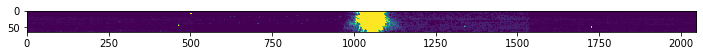

In [43]:
#A check to ensure the star is in the file
file = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_rateints.fits' #random file from the rateints list
HDUList = fits.open(file)
#HDUList.info()

image2D = HDUList[1].data[0]
image2D.shape

fig, ax = plt.subplots(figsize=(12,5))
ax.imshow(image2D, vmin=0, vmax=50)
#ax.plot(image2D[32,:])
#ax.set_xlim(900,1000)

In [31]:
asn_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False'
level2_asn = (os.path.join(asn_dir, 'level2_asn.json'))
asn_stage2 = asn_from_list(['/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_rateints.fits'],rule=DMSLevel2bBase)
with open(level2_asn, 'w') as fh:
   fh.write(asn_stage2.dump()[1])

# $\textbf{Stage 2}$


In [32]:
#The file to use is the stage 2 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage2 = Image2Pipeline()

# Specify that you want results saved to a file
pipeline_stage2.save_results = True
pipeline_stage2.output_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False'

# Execute the pipeline using the run method
result_stage2 = pipeline_stage2.run(level2_asn)

2021-09-29 13:37:49,844 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


[stpipe.Image2Pipeline:INFO] Image2Pipeline instance created.


2021-09-29 13:37:49,850 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


[stpipe.Image2Pipeline.bkg_subtract:INFO] BackgroundStep instance created.


2021-09-29 13:37:49,858 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


[stpipe.Image2Pipeline.assign_wcs:INFO] AssignWcsStep instance created.


2021-09-29 13:37:49,864 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


[stpipe.Image2Pipeline.flat_field:INFO] FlatFieldStep instance created.


2021-09-29 13:37:49,869 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


[stpipe.Image2Pipeline.photom:INFO] PhotomStep instance created.


2021-09-29 13:37:49,875 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


[stpipe.Image2Pipeline.resample:INFO] ResampleStep instance created.


2021-09-29 13:37:50,385 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/level2_asn.json',).


[stpipe.Image2Pipeline:INFO] Step Image2Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/level2_asn.json',).


2021-09-29 13:37:50,399 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 's

[stpipe.Image2Pipeline:INFO] Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output

2021-09-29 13:37:50,853 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


[stpipe.Image2Pipeline:INFO] Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-09-29 13:37:50,865 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0031.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for AREA reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0031.fits'.


2021-09-29 13:37:50,867 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for CAMERA reference file is 'N/A'.


2021-09-29 13:37:50,869 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for COLLIMATOR reference file is 'N/A'.


2021-09-29 13:37:50,870 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for DFLAT reference file is 'N/A'.


2021-09-29 13:37:50,872 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for DISPERSER reference file is 'N/A'.


2021-09-29 13:37:50,873 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_distortion_0089.asdf'.


[stpipe.Image2Pipeline:INFO] Prefetch for DISTORTION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_distortion_0089.asdf'.


2021-09-29 13:37:50,878 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for DRIZPARS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


2021-09-29 13:37:50,880 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for FFLAT reference file is 'N/A'.


2021-09-29 13:37:50,881 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_filteroffset_0004.asdf'.


[stpipe.Image2Pipeline:INFO] Prefetch for FILTEROFFSET reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_filteroffset_0004.asdf'.


2021-09-29 13:37:50,885 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_flat_0298.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for FLAT reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_flat_0298.fits'.


2021-09-29 13:37:50,887 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for FORE reference file is 'N/A'.


2021-09-29 13:37:50,889 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for FPA reference file is 'N/A'.


2021-09-29 13:37:50,891 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for IFUFORE reference file is 'N/A'.


2021-09-29 13:37:50,892 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for IFUPOST reference file is 'N/A'.


2021-09-29 13:37:50,894 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for IFUSLICER reference file is 'N/A'.


2021-09-29 13:37:50,895 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for MSA reference file is 'N/A'.


2021-09-29 13:37:50,897 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for OTE reference file is 'N/A'.


2021-09-29 13:37:50,898 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for PHOTOM reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits'.


2021-09-29 13:37:50,904 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for REGIONS reference file is 'N/A'.


2021-09-29 13:37:50,906 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for SFLAT reference file is 'N/A'.


2021-09-29 13:37:50,907 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for SPECWCS reference file is 'N/A'.


2021-09-29 13:37:50,909 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-09-29 13:37:50,910 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for WFSSBKG reference file is 'N/A'.


2021-09-29 13:37:50,914 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


[stpipe.Image2Pipeline:INFO] Starting calwebb_image2 ...


2021-09-29 13:37:50,933 - stpipe.Image2Pipeline - INFO - Processing product /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3


[stpipe.Image2Pipeline:INFO] Processing product /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3


2021-09-29 13:37:50,936 - stpipe.Image2Pipeline - INFO - Working on input /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_rateints.fits ...


[stpipe.Image2Pipeline:INFO] Working on input /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_rateints.fits ...
[jwst.datamodels.util:DEBUG] Opening /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_rateints.fits as <class 'jwst.datamodels.cube.CubeModel'>
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] FITS hash matches. Skipping FITS updating.
[stdatamodels.fits_support:DEBUG] Skipping FITS keyword updating except for BinTableHDU and its associated header keywords.


2021-09-29 13:37:51,663 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


[stpipe.Image2Pipeline.assign_wcs:INFO] Step assign_wcs running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


2021-09-29 13:37:51,668 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


[stpipe.Image2Pipeline.assign_wcs:INFO] Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be fo

[py.warnings:WARNING] /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



[jwst.assign_wcs.util:INFO] Update S_REGION to POLYGON ICRS  175.560846873 26.702895140 175.560844974 26.703457812 175.540802246 26.703431012 175.540794772 26.702865173
[jwst.assign_wcs.assign_wcs:INFO] assign_wcs updated S_REGION to POLYGON ICRS  175.560846873 26.702895140 175.560844974 26.703457812 175.540802246 26.703431012 175.540794772 26.702865173
[jwst.assign_wcs.assign_wcs:INFO] COMPLETED assign_wcs


2021-09-29 13:37:53,278 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


[stpipe.Image2Pipeline.assign_wcs:INFO] Step assign_wcs done


2021-09-29 13:37:53,582 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


[stpipe.Image2Pipeline.flat_field:INFO] Step flat_field running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


2021-09-29 13:37:53,585 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


[stpipe.Image2Pipeline.flat_field:INFO] Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stpipe.Image2Pipeline.flat_field:DEBUG] Input is CubeModel of exposure type NRC_TSIMAGE
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using defa

2021-09-29 13:37:55,423 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


[stpipe.Image2Pipeline.flat_field:INFO] Step flat_field done


2021-09-29 13:37:55,729 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


[stpipe.Image2Pipeline.photom:INFO] Step photom running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_rateints.fits>,).


2021-09-29 13:37:55,734 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'inverse': False, 'source_type': None}


[stpipe.Image2Pipeline.photom:INFO] Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'inverse': False, 'source_type': None}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stpipe.Image2Pipeline.photom:DEBUG] Input is CubeModel
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" 

2021-09-29 13:37:55,819 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits


[stpipe.Image2Pipeline.photom:INFO] Using photom reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits


2021-09-29 13:37:55,821 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0031.fits


[stpipe.Image2Pipeline.photom:INFO] Using area reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0031.fits
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.photom.photom:INFO] Using instrument: NIRCAM
[jwst.photom.photom:INFO]  detector: NRCA3
[jwst.photom.photom:INFO]  exp_type: NRC_TSIMAGE
[jwst.photom.photom:INFO]  filter: WLP4
[jwst.photom.photom:INFO]  pupil: CLEAR
[jwst.datamodels.util:DEBUG] Opening /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits as <class 'jwst.datamodels.photom.NrcImgPhotomModel'>
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.f

2021-09-29 13:37:56,587 - stpipe.Image2Pipeline.photom - INFO - Step photom done


[stpipe.Image2Pipeline.photom:INFO] Step photom done


2021-09-29 13:37:56,589 - stpipe.Image2Pipeline - INFO - Finished processing product /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3


[stpipe.Image2Pipeline:INFO] Finished processing product /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3


2021-09-29 13:37:56,591 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


[stpipe.Image2Pipeline:INFO] ... ending calwebb_image2


2021-09-29 13:37:57,834 - stpipe.Image2Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_calints.fits


[stpipe.Image2Pipeline:INFO] Saved model in /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_calints.fits


2021-09-29 13:37:57,838 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[stpipe.Image2Pipeline:INFO] Step Image2Pipeline done


In [33]:
#generate an association file required for stage 3
asn_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False'
level3_asn = (os.path.join(asn_dir, 'level3_asn.json'))
asn_stage3 = asn_from_list(['/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_calints.fits'], product_name ='DataChallengeSimulation_nrca3_level3_asn')
with open(level3_asn, 'w') as fh:
   fh.write(asn_stage3.dump()[1])

# $\textbf{Stage 3}$


In [34]:
#The file to use is the stage 3 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage3 = Tso3Pipeline()

pipeline_stage3.outlier_detection.skip = True

# Specify that you want results saved to a file
pipeline_stage3.save_results = True
pipeline_stage3.output_dir = '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False'

# Execute the pipeline using the run method
result_stage3 = pipeline_stage3.run(level3_asn)

2021-09-29 13:37:57,871 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.


[stpipe.Tso3Pipeline:INFO] Tso3Pipeline instance created.


2021-09-29 13:37:57,879 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


[stpipe.Tso3Pipeline.outlier_detection:INFO] OutlierDetectionStep instance created.


2021-09-29 13:37:57,885 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.


[stpipe.Tso3Pipeline.tso_photometry:INFO] TSOPhotometryStep instance created.


2021-09-29 13:37:57,896 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.


[stpipe.Tso3Pipeline.extract_1d:INFO] Extract1dStep instance created.


2021-09-29 13:37:57,900 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.


[stpipe.Tso3Pipeline.white_light:INFO] WhiteLightStep instance created.


2021-09-29 13:37:58,196 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/level3_asn.json',).


[stpipe.Tso3Pipeline:INFO] Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/level3_asn.json',).


2021-09-29 13:37:58,208 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'scale_detection': False, 'steps': {'outlier_detection': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 's

[stpipe.Tso3Pipeline:INFO] Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'scale_detection': False, 'steps': {'outlier_detection': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'all

2021-09-29 13:37:58,840 - stpipe.Tso3Pipeline - INFO - Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_calints.fits' reftypes = ['gain', 'readnoise']


[stpipe.Tso3Pipeline:INFO] Prefetching reference files for dataset: 'jw00042001001_01101_00001-seg013_nrca3_calints.fits' reftypes = ['gain', 'readnoise']


2021-09-29 13:37:58,849 - stpipe.Tso3Pipeline - INFO - Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.


[stpipe.Tso3Pipeline:INFO] Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.


2021-09-29 13:37:58,852 - stpipe.Tso3Pipeline - INFO - Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.


[stpipe.Tso3Pipeline:INFO] Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.


2021-09-29 13:37:58,855 - stpipe.Tso3Pipeline - INFO - Starting calwebb_tso3...


[stpipe.Tso3Pipeline:INFO] Starting calwebb_tso3...
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.datamodels.container:DEBUG] Filtering datasets based on allowed exptypes ['science']:
[jwst.datamodels.container:DEBUG] Files accepted for processing /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_calints.fits:
[jwst.datamodels.util:DEBUG] Opening /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/jw00042001001_01101_00001-seg013_nrca3_calints.fits as <class 'jwst.datamodels.cube.CubeModel'>
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value o

[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[st

[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[st

[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[st

[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[st

2021-09-29 13:38:15,434 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


[stpipe.Tso3Pipeline:INFO] Performing outlier detection on input images ...


2021-09-29 13:38:15,767 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step outlier_detection running with args (<ModelContainer>,).


2021-09-29 13:38:15,773 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-09-29 13:38:15,775 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step skipped.


2021-09-29 13:38:15,871 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection done


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step outlier_detection done


2021-09-29 13:38:16,308 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_calints.fits>,).


[stpipe.Tso3Pipeline.tso_photometry:INFO] Step tso_photometry running with args (<CubeModel(152, 64, 2048) from jw00042001001_01101_00001-seg013_nrca3_calints.fits>,).


2021-09-29 13:38:16,312 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'save_catalog': False}


[stpipe.Tso3Pipeline.tso_photometry:INFO] Step tso_photometry parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False', 'save_catalog': False}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stpipe.Tso3Pipeline.tso_photometry:DEBUG] Reference file name = /fenrirdata1/kg_data/crds_cache/references/jwst/nirca

2021-09-29 13:38:16,683 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry done


[stpipe.Tso3Pipeline.tso_photometry:INFO] Step tso_photometry done


2021-09-29 13:38:16,686 - stpipe.Tso3Pipeline - INFO - Writing Level 3 photometry catalog /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/DataChallengeSimulation_nrca3_level3_asn_phot.ecsv


[stpipe.Tso3Pipeline:INFO] Writing Level 3 photometry catalog /fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/DataChallengeSimulation_nrca3_level3_asn_phot.ecsv


2021-09-29 13:38:16,727 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline done


[stpipe.Tso3Pipeline:INFO] Step Tso3Pipeline done


Pipeline Calculated Net Aperture Sum std: 5842.731863470847
Pipeline Calculated Aperture Background std: 8241.579255001307
Pipeline Calculated Annulus Mean std: 8241.579255001318
Pipeline Calculated Annulus Sum std: 8241.579255001307


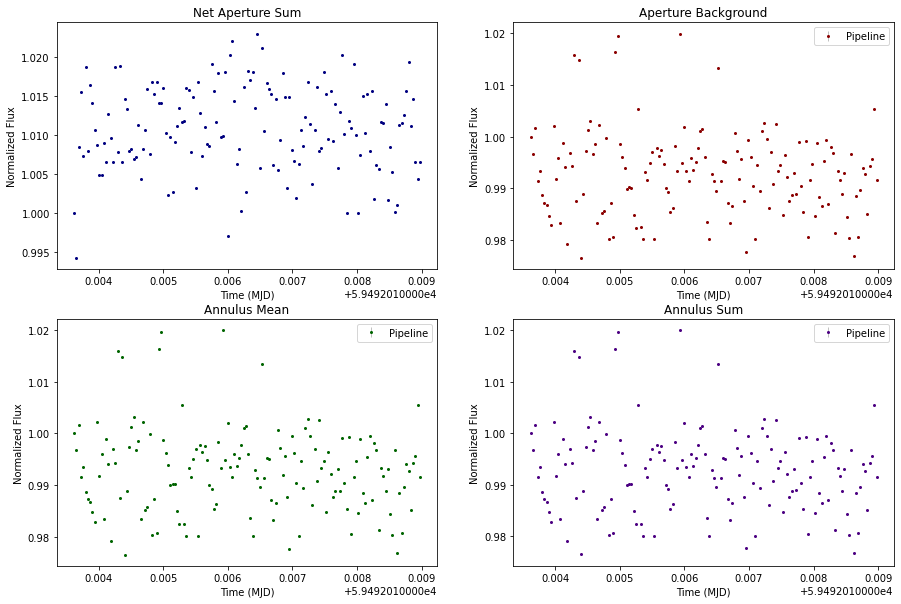

In [48]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))

#JWST pipeline: net aperture
dat = ascii.read('/fenrirdata1/kg_data/pipeline_output/DataChallengeSimulation/JumpSkip_Test/Skip_False/DataChallengeSimulation_nrca3_level3_asn_phot.ecsv') #call the data 
normalized_net_aperture_sum_pipeline = dat['net_aperture_sum'].value/dat['net_aperture_sum'][0].value #normalized net aperture sum
std_net_aperture_sum_pipeline = np.std(normalized_net_aperture_sum_pipeline[0:20]) #calculated standard deviation
relative_error_net_aperture_sum_pipeline = (dat['net_aperture_sum_err'].value/dat['net_aperture_sum'].value)*10**6 #ppm

print(style.BOLD+"Pipeline Calculated Net Aperture Sum std:"+style.END + " " +str(std_net_aperture_sum_pipeline*10**6))
#print(style.BOLD+"Relative Errors Net Aperture Sum:"+style.END + " " +str(relative_error_net_aperture_sum_pipeline))

axs[0,0].errorbar(dat['MJD'],normalized_net_aperture_sum_pipeline,yerr=dat['net_aperture_sum_err'].value,color='navy',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,0].set_title("Net Aperture Sum")
axs[0,0].set_xlabel("Time (MJD)")
axs[0,0].set_ylabel("Normalized Flux")

#JWST pipeline: aperature background
normalized_aperture__bkg_pipeline = dat['aperture_bkg'].value/dat['aperture_bkg'][0].value #normalized aperture bkg
std_aperture_bkg_pipeline = np.std(normalized_aperture__bkg_pipeline[0:20]) #calculated standard deviation
relative_error_aperture_bkg_pipeline = (dat['aperture_bkg_err'].value/dat['aperture_bkg'].value)*10**6 #ppm

print(style.BOLD+"Pipeline Calculated Aperture Background std:"+style.END + " " +str(std_aperture_bkg_pipeline*10**6))
#print(style.BOLD+"Relative Errors Aperture Background:"+style.END + " " +str(relative_error_aperture_bkg_pipeline))

axs[0,1].errorbar(dat['MJD'],normalized_aperture__bkg_pipeline,yerr=dat['aperture_bkg_err'].value,color='darkred',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,1].set_title("Aperture Background")
axs[0,1].set_xlabel("Time (MJD)")
axs[0,1].set_ylabel("Normalized Flux")
axs[0,1].legend()


#JWST pipeline: annulus mean
normalized_annulus_mean_pipeline = dat['annulus_mean'].value/dat['annulus_mean'][0].value #normalized annulus mean
std_annulus_mean_pipeline = np.std(normalized_annulus_mean_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_mean_pipeline = (dat['annulus_mean_err'].value/dat['annulus_mean'].value)*10**6 #ppm

print(style.BOLD+"Pipeline Calculated Annulus Mean std:"+style.END + " " +str(std_annulus_mean_pipeline*10**6))
#print(style.BOLD+"Relative Errors Annulus Mean:"+style.END + " " +str(relative_error_annulus_mean_pipeline))

axs[1,0].errorbar(dat['MJD'],normalized_annulus_mean_pipeline,yerr=dat['annulus_mean_err'].value,color ='darkgreen',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,0].set_title("Annulus Mean")
axs[1,0].set_xlabel("Time (MJD)")
axs[1,0].set_ylabel("Normalized Flux")
axs[1,0].legend()

#JWST pipeline: annulus sum
normalized_annulus_sum_pipeline = dat['annulus_sum'].value/dat['annulus_sum'][0].value #normalized annulus sum
std_annulus_sum_pipeline = np.std(normalized_annulus_sum_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_sum_pipeline = (dat['annulus_sum_err'].value/dat['annulus_sum'].value)*10**6 #ppm

print(style.BOLD+"Pipeline Calculated Annulus Sum std:"+style.END + " " +str(std_annulus_sum_pipeline*10**6))
#print(style.BOLD+"Relative Errors Annulus Sum:"+style.END + " " +str(relative_error_annulus_sum_pipeline))

axs[1,1].errorbar(dat['MJD'],normalized_annulus_sum_pipeline,yerr=dat['annulus_sum_err'].value,color = 'indigo',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,1].set_title("Annulus Sum")
axs[1,1].set_xlabel("Time (MJD)")
axs[1,1].set_ylabel("Normalized Flux")
axs[1,1].legend()